## NEW: ULMFiT-2 Blue-or-Red Training: 2022 Tweets

In [1]:
from fastai.text.all import *

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from ideology_utils import *

#### Grab Congressional tweets for each week and create a dataframe

In [82]:
path = Path()
path_22 = path/'tweets/'

In [83]:
df = pd.concat(map(tweets2df, path_22.rglob("tweets-congress*/*")))

#### Label each tweet according by the handle of the legislator

In [84]:
df = label_tweets_of_legislators(df)
df = df[['text','party']]

#### Preprocess each of the tweets

In [85]:
df = preprocess_tweets(df)

#### Shuffle and create Training (which Validation) and Testing Sets

In [86]:
df = df.sample(frac=1).reset_index(drop=True)

In [87]:
n_tr = Int(.9*(len(df)))
n_tr

27096

In [88]:
df_train, df_test = df[:n_tr], df[n_tr+1:]

### Fine-tuning a language model on Congressional Tweets from 2022

In [98]:
dls_lm = TextDataLoaders.from_df(df_train, is_lm=True, valid_pct=0.1, bs=128)

In [99]:
dls_lm.show_batch(max_n=5)

,text,text_
0,xxbos xxmaj today is # headstart 's 57th birthday ! xxmaj join me in celebrating the nationwide impact of this vital program and the 39 + million # headstart alumni who have made such a difference in xxmaj nevada and across the country . http xxbos xxmaj my heart goes out to the families & & loved ones of xxmaj dr . xxmaj john xxmaj cheng who was killed during a senseless,xxmaj today is # headstart 's 57th birthday ! xxmaj join me in celebrating the nationwide impact of this vital program and the 39 + million # headstart alumni who have made such a difference in xxmaj nevada and across the country . http xxbos xxmaj my heart goes out to the families & & loved ones of xxmaj dr . xxmaj john xxmaj cheng who was killed during a senseless mass
1,economic cooperation & & the different way we need to look at security in xxmaj europe now that xxmaj russia has so xxunk invaded xxmaj ukraine . 2 / 4 xxbos xxmaj yesterday we met with xxup blm xxmaj director xxmaj tracy stone - xxunk to discuss xxmaj new xxmaj mexico ’s priorities & & the need to protect our lands waters & & resources & & consult with our communities on,cooperation & & the different way we need to look at security in xxmaj europe now that xxmaj russia has so xxunk invaded xxmaj ukraine . 2 / 4 xxbos xxmaj yesterday we met with xxup blm xxmaj director xxmaj tracy stone - xxunk to discuss xxmaj new xxmaj mexico ’s priorities & & the need to protect our lands waters & & resources & & consult with our communities on any
2,toxic blend of racism xxunk and gun violence is domestic terrorism . http xxbos a teacher told me “ i see the fear in my students ’ eyes . xxmaj they have so much courage but they should n’t need courage to walk into their classroom . ”i agree with her which is why xxmaj i ’m urging my colleagues to act . xxmaj there are popular commonsense steps we can take,blend of racism xxunk and gun violence is domestic terrorism . http xxbos a teacher told me “ i see the fear in my students ’ eyes . xxmaj they have so much courage but they should n’t need courage to walk into their classroom . ”i agree with her which is why xxmaj i ’m urging my colleagues to act . xxmaj there are popular commonsense steps we can take to
3,out here soon ! # xxunk xxbos xxmaj as xxmaj i 've had some time to think on last week 's tragic events i wanted to share some xxunk . xxmaj the breakdown of the traditional xxmaj american family & & our shared values directly xxunk with the rise in the number of troubled individuals who commit mass xxunk / 3 xxbos i look forward to continuing to work with the xxmaj,here soon ! # xxunk xxbos xxmaj as xxmaj i 've had some time to think on last week 's tragic events i wanted to share some xxunk . xxmaj the breakdown of the traditional xxmaj american family & & our shared values directly xxunk with the rise in the number of troubled individuals who commit mass xxunk / 3 xxbos i look forward to continuing to work with the xxmaj secretary
4,’ve got to start addressing the root cause behind these senseless acts . xxmaj we ’ve got to start taking care of one xxunk : / / t.co / xxunk xxbos xxmaj powerful evidence released today by @user & & @user xxunk the horrors occurring in xxmaj xinjiang . xxmaj these are nothing short of modern day concentration camps xxunk as “ vocational training centers . ” # xinjiangpolicefiles # xxunk xxbos,got to start addressing the root cause behind these senseless acts . xxmaj we ’ve got to start taking care of one xxunk : / / t.co / xxunk xxbos xxmaj powerful evidence released today by @user & & @user xxunk the horrors occurring in xxmaj xinjiang . xxmaj these are nothing short of modern day concentration camps xxunk as “ vocational training centers . ” # xinjiangpolicefiles # xxunk xxbos xxmaj


In [100]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

SuggestedLRs(valley=0.009120108559727669)

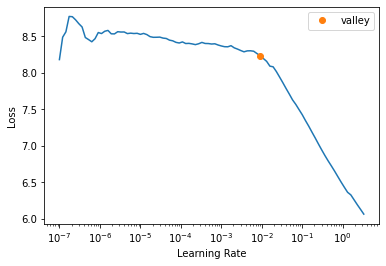

In [46]:
learn.lr_find()

In [101]:
learn.fit_one_cycle(3, .008)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.501612,3.723868,0.326069,41.424301,00:47
1,3.876400,3.496455,0.347616,32.998257,00:47
2,3.691785,3.464839,0.350623,31.971327,00:47


In [102]:
learn.unfreeze()
learn.fit_one_cycle(3, .008)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.499863,3.290524,0.371759,26.856920,00:48
1,3.212859,3.078983,0.399195,21.736286,00:47
2,2.878273,3.021015,0.408849,20.512100,00:48


In [103]:
learn.unfreeze()
learn.fit_one_cycle(2, .008)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.027977,3.097367,0.396241,22.139576,00:48
1,2.791495,2.997048,0.414962,20.026329,00:48


In [104]:
learn.save_encoder('ulmfit-lm-2022')

### Training a text classifier

In [105]:
dls_clas = TextDataLoaders.from_df(df_train, valid_pct=.2, text_col='text', label='party',           text_vocab=dls_lm.vocab, bs=128)

In [106]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [107]:
learn = learn.load_encoder('ulmfit-lm-2022') # Reuse language model

SuggestedLRs(valley=0.0014454397605732083)

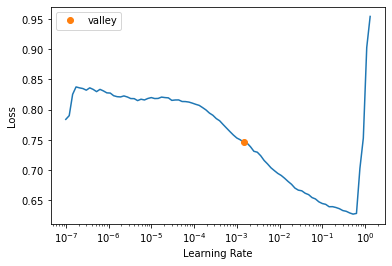

In [108]:
learn.lr_find()

In [109]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.513232,0.474964,0.767485,00:08
1,0.471911,0.443060,0.781694,00:08


In [110]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.485077,0.433368,0.787968,00:09
1,0.416512,0.382542,0.816018,00:09
2,0.334801,0.375291,0.827090,00:09


In [111]:
learn.freeze_to(-5)
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.316442,0.396247,0.822292,00:16
1,0.295670,0.365037,0.835948,00:16
2,0.188301,0.395087,0.853109,00:16
3,0.126308,0.434397,0.855139,00:16


In [112]:
learn.save("clss-fifth-2022")

Path('models/clss-fifth-2022.pth')

In [113]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.114806,0.491273,0.851449,00:16
1,0.094655,0.474802,0.852740,00:16


In [114]:
learn.export("ulmfit-2022.pkl")

### Evaluate Model on Test Dataset

In [115]:
dl_test = learn.dls.test_dl(df_test, with_labels=True)

In [116]:
predicts, actuals = learn.get_preds(dl = dl_test)
predicts, actuals = np.argmax(predicts, axis=1).numpy(), actuals.numpy()

In [117]:
sum(predicts == actuals)/len(predicts)

0.8531561461794019

The **85.3%** accuracy of the model predictions on the **Test Data** is nearly identical to that of the accuracy model prediction on the **Training Data.**

###  Load Model

In [121]:
path_19 = '/home/cdaniels/fastai-projects/blue-or-red/data_full'
ideology_score(Path(path_19)/"McConnellPress.csv","ulmfit-2022.pkl")

[0.68, 0.66, 1451]

In [122]:
path_22 = path/'tweets'/'tweets-congress-2022-05-24'
ideology_score(path_22/'McConnellPress.csv', "ulmfit-2022.pkl")

[0.94, 0.92, 18]